In [41]:
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import random

In [42]:
def get_points(num, minval = -1.0, maxval = 1.0, dim = 2):
    points = np.asarray([[None for i in range(dim)] for j in range(num)])
    for i in range(dim):
        for j in range(num):
            points[j,i] = random.uniform(minval, maxval)    
    return np.asarray(points)

In [43]:
def get_target_fn(points):
    # y = mx + b
    #returns m, b
    x1 = points[0,0]
    y1 = points[0,1]
    x2 = points[1,0]
    y2 = points[1,1]
    m = (y2-y1)/(x2-x1)
    b = y1 - m*(x1)
    return m, b

In [44]:
def add_bias_to_x(x):
    bias = np.ones(len(x[:,0]))
    x = np.c_[x,bias]
    return x

In [45]:
def eval_target_fn(datapoints,m,b):
    y = np.zeros(len(datapoints))
    for i in range(len(datapoints)):
        if datapoints[i,1] < datapoints[i,0]*m + b:
            y[i] = -1
        else:
            y[i] = 1
    return y

In [46]:
def get_sign(vec):
    sign = np.zeros(len(vec))
    for i in range(len(vec)):
        if vec[i] == 0:
            sign[i] = 0.0
        else:
            if vec[i] < 0:
                sign[i] = -1.0
            else:
                sign[i] = 1.0
    return sign 

In [47]:
def get_target(N,minval = -1.0, maxval = 1.0, dim = 2):
    
    target_fn_points = get_points(dim)
    m, b  = get_target_fn(target_fn_points)
    x = get_points(N)
    y = eval_target_fn(x,m,b)
    return m,b,x,y

In [48]:
def plot_target(m,b,x,y):
    plt.plot((-1,1), (get_y(-1,m,b), get_y(1,m,b)))
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    neg_x = [x[i,0] for i in range(len(x[:,0])) if y[i] < 0]
    pos_x = [x[i,0] for i in range(len(x[:,0])) if y[i] > 0]
    neg_y = [x[i,1] for i in range(len(x[:,1])) if y[i] < 0]
    pos_y = [x[i,1] for i in range(len(x[:,1])) if y[i] > 0]
    plt.plot(neg_x, neg_y,'r*')
    plt.plot(pos_x, pos_y,'b*')
    plt.title('Target data')
    plt.show()

In [157]:
def plot_iter(m,b,x,y,w, iteration):
    plt.plot((-1,1), (get_y(-1,m,b), get_y(1,m,b)),'g', label = 'target_fn')
    print(w)
    plt.plot((-1,1), ((w[0]-w[2])/w[1], (-w[0]-w[2])/w[1]),'c',label='learned_fn')
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    neg_x = [x[i,0] for i in range(len(x[:,0])) if w.dot(x[i,:].transpose()) <= 0]
    pos_x = [x[i,0] for i in range(len(x[:,0])) if w.dot(x[i,:].transpose()) > 0]
    neg_y = [x[i,1] for i in range(len(x[:,1])) if w.dot(x[i,:].transpose()) <= 0]
    pos_y = [x[i,1] for i in range(len(x[:,1])) if w.dot(x[i,:].transpose()) > 0]
    plt.plot(neg_x, neg_y,'r*')
    plt.plot(pos_x, pos_y,'b*')
    plt.title('Logistic Regression, iter. '+str(iteration))
    plt.xlabel('x_1')
    plt.ylabel('x_2')
    plt.legend()
    plt.savefig('Logistic_Regression.jpg')
    plt.show()

In [85]:
def get_y(x,m,b):
    return m*x + b

In [86]:
def init_weights(dim=2):
    return np.zeros(dim+1)

In [87]:
def update_weights(w,x,y,idx):
    w = w + y[idx]*x[idx]
    return w
    

In [88]:
def get_misclassified_point_idx(sign, y):
    idx = []
    for i in range(len(sign)):
        if sign[i] != y[i]:
            idx.append(i)
    return idx

In [89]:
def estimate_disagreement(w, m, b, num_test_points = 100):
    test_x = get_points(num_test_points)
    test_y = eval_target_fn(test_x,m,b)
    test_x = add_bias_to_x(test_x)
    vec = w.dot(test_x.transpose())
    sign = get_sign(vec)
    idx = get_misclassified_point_idx(sign,test_y)
    disagreement_prob = float(len(idx))/float(num_test_points)
    return disagreement_prob
    

In [139]:
def logistic_regression_sgd(N, lr = 0.01,threshold = 0.01, minval = -1.0, maxval = 1.0, dim = 2, plot_fn = False):
    m,b,x,y = get_target(N)
    x = add_bias_to_x(x)
    w = init_weights()
    iter_count = 0
    diff = 100
    while diff > threshold: #while there are misclassified points
        iter_count += 1
        rand_N = list(range(N))
        random.shuffle(rand_N)
        w_prev = np.copy(w)
        w_ = np.copy(w)
        for n in rand_N:
            #print(n)
            x_n = x[n,:]
            y_n = y[n]
            err = (y_n*x_n)/(1+np.exp(y_n*np.dot(w_,x_n)))
            w_ = w_ + lr*err
        w = np.copy(w_)
        diff = np.linalg.norm(w-w_prev)
        
    e_out = estimate_disagreement(w,m,b)
    if plot_fn:
        plot_iter(m,b,x,y,w,iter_count)
    return iter_count, e_out
        

In [137]:
N = 100
iterations = 100
num_iters = []
disagreement_probs = []
for i in range(iterations):
    iter_count, disagreement = logistic_regression_sgd(N)
    num_iters.append(iter_count)
    #print(iter_count)
    disagreement_probs.append(disagreement)

print(len(num_iters))
print(np.mean(num_iters))
print(np.mean(disagreement_probs))

100
338.93
0.0234


[-8.178366450004003 1.5241806426943323 -3.212555981907816]


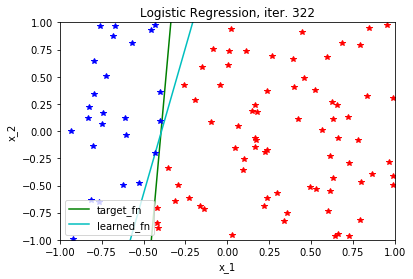

In [160]:
iter_count, disagreement = logistic_regression_sgd(N, plot_fn=True)
